In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

In [12]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=2000, replications=1, n=500,
    # allowed_functions=['identity']
)
data

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean
0,100445,-1.615771,0.763502,-5.000000,-1.773810,0.439773,1.330049,0.075778,1.061808,tanh,identity,tanh_scaled,rescaled_identity,-0.807208,0.000,-0.804269,0.002939,"[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...","[-1.1411653221810727, -0.5172453280730545, 2.1...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[-0.7471893186577202, -0.8054176708785077, -0....",0.853590,-0.924625,1,0,0.356,-0.241661
1,963082,-0.878237,-2.175142,-4.994997,-1.238194,0.623532,0.180746,0.191658,1.829543,bounded_linear,log1p_abs,tanh_scaled,sin,0.134076,0.552,0.112580,-0.021496,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...","[-2.881672897747387, 4.4666836571915365, 0.927...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[-0.11516105651382981, -0.8396575608272068, -0...",0.999997,-0.999993,1,0,0.316,-0.402548
2,180730,-0.800259,0.134834,-4.989995,-0.978699,0.365063,0.324318,0.313807,0.357082,sigmoid,sigmoid,softplus,exp_clipped,-1.058761,0.000,0.008320,1.067080,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...","[0.11373884173854355, 0.42373128910383623, -0....","[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.5725565019841973, 0.006737946999085467, 0.0...",1.459768,0.006738,1,0,0.358,0.409917
3,815280,0.587580,-0.117269,-4.984992,-0.971284,0.527745,0.057168,1.273870,1.392488,cos,identity,softplus,sigmoid,-0.471262,0.006,0.032266,0.503528,"[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0.5496360590444653, -0.5977447900966681, -0.6...","[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...","[0.1499000356181591, 0.8245240799850314, 0.018...",0.990873,0.000033,1,0,0.486,0.276679
4,587636,1.247927,0.820549,-4.979990,0.266371,0.764278,0.107473,0.726705,0.176679,exp_clipped,rescaled_identity,tanh_scaled,bounded_linear,-0.933191,0.000,-0.934718,-0.001526,"[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...","[-0.15856431783289562, -0.2177740916917188, 0....","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-1.0, -0.9937096977795081, -0.944966551487488...",0.241695,-1.000000,1,0,0.950,-0.889404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,491404,1.753570,1.014928,4.979990,-2.012606,0.483699,1.329643,0.058331,0.525727,tanh,exp_neg_sq,softplus,sigmoid,0.479452,1.000,0.988362,0.508910,"[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...","[0.26080195619008983, -0.0979324264394692, 1.1...","[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.9559692405638145, 0.9538578576103975, 0.988...",0.992797,0.109254,1,0,0.552,0.611405
1996,918764,-1.036336,0.498822,4.984992,0.772584,0.968753,0.916422,0.104629,0.746125,bounded_linear,bounded_linear,probit,identity,4.986444,1.000,4.997237,0.010792,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-1.1358164851614008, 0.1830110408021814, 0.92...","[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[4.857566799392568, -0.01749828280190874, 4.98...",5.408248,-0.403714,1,0,0.266,1.331953
1997,135219,-1.471666,0.156837,4.989995,-0.704111,0.420174,1.152057,0.325561,0.155698,sigmoid_shifted,sin,softplus,zero_centered_tanh,1.004105,1.000,0.999881,-0.004224,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0.09156457004640349, -0.016070271405886405, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[-0.2473328563759324, -0.18260787602155715, 0....",0.999985,-0.742174,1,0,0.316,0.307000
1998,550886,-1.047921,-0.081572,4.994997,1.099244,0.370837,0.876093,0.510913,0.398065,exp_neg_sq,sin,probit,sigmoid_shifted,0.000621,0.496,0.500118,0.499497,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.47211022387354173, -0.24738940476989174, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, ...","[0.43212330038160696, 0.1119070816613413, 0.14...",0.995178,0.024012,1,0,0.328,0.437588


In [16]:
pd.DataFrame(data.iloc[80]['X']).describe()
data['X_mean'].describe()

count    2000.000000
mean        0.445951
std         0.167417
min         0.090000
25%         0.302000
50%         0.440000
75%         0.556000
max         0.950000
Name: X_mean, dtype: float64

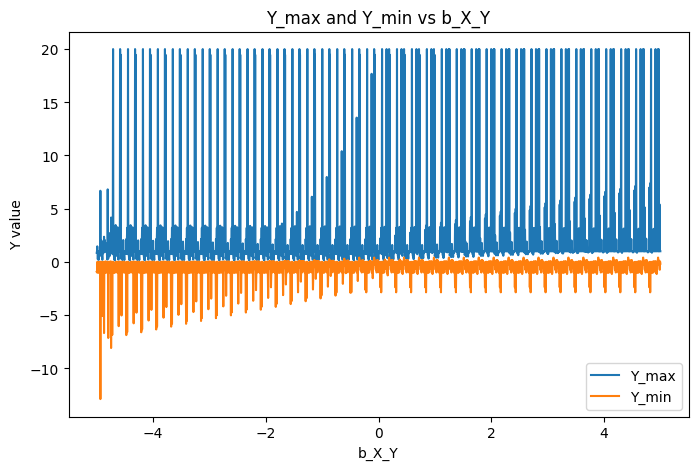

In [14]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

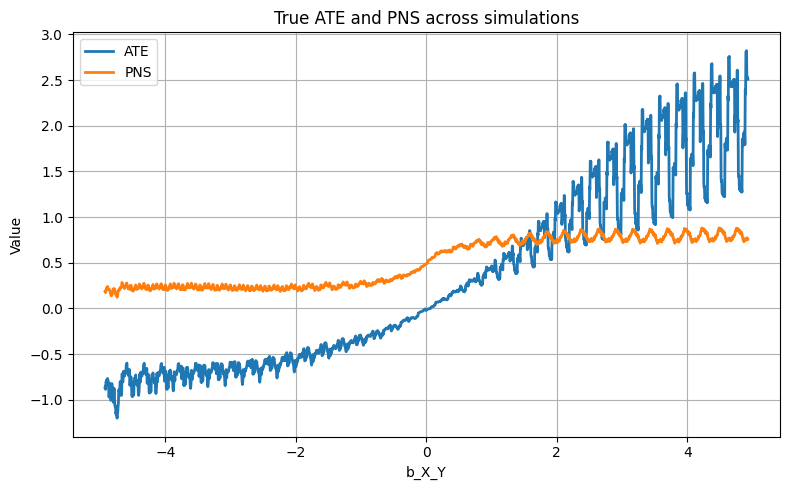

In [15]:
PlottingUtil.plot_ate_pns(data, window=30)

In [4]:
binaryIV = BinaryIV('IV Dag', data)

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run_all_bounding_algorithms(algorithms)

Running ATE_2SLS-0.99...
ATE_2SLS-0.99 completed in 0.19 seconds.
Running ATE_2SLS-0.98...
ATE_2SLS-0.98 completed in 0.25 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 6.28 seconds.
Running ATE_autobound...
ATE_autobound completed in 4.71 seconds.
Running ATE_entropybounds-0.80...
ATE_entropybounds-0.80 completed in 0.59 seconds.
Running ATE_entropybounds-0.20...
ATE_entropybounds-0.20 completed in 0.59 seconds.
Running ATE_entropybounds-0.10...
ATE_entropybounds-0.10 completed in 0.63 seconds.
Running ATE_nonpara...
ATE_nonpara completed in 0.01 seconds.
Total runtime: 13.26 seconds.


             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
           PNS_nonpara          0.00            16.00          0.1784
       PNS_causaloptim          4.00             9.38          0.4198
         PNS_autobound          1.00             0.00          0.4283
PNS_entropybounds-0.10          0.00             0.00          0.5021
PNS_entropybounds-0.20          0.00             0.00          0.5752
PNS_entropybounds-0.80          0.00             0.00          0.7197
    PNS_zaffalonbounds           N/A              N/A             N/A


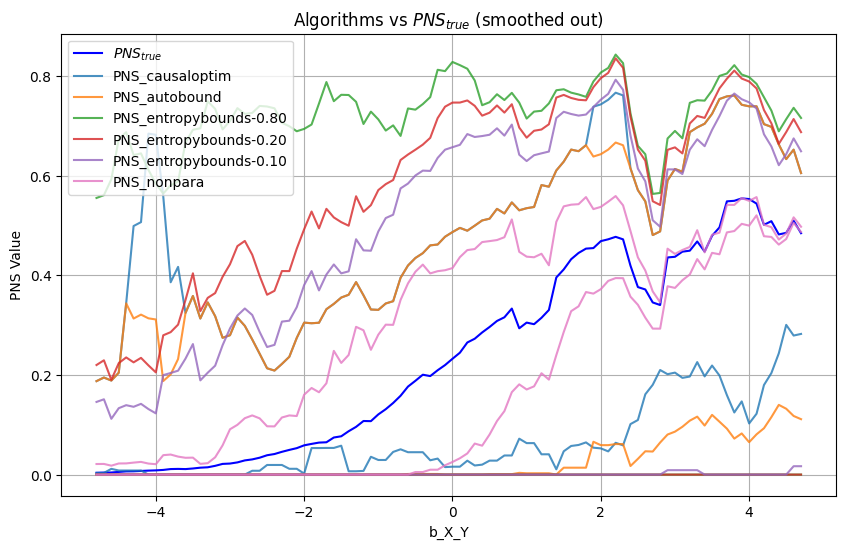

In [28]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('PNS')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'PNS', ate_algs, 5, False)